<a href="https://colab.research.google.com/github/larrygoyeau/Artificial-Intelligence-for-Partial-Differential-Equations/blob/master/prediction_de_C_et_W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation
import sys
np.set_printoptions(threshold=sys.maxsize)

from scipy.interpolate import interp1d

#Import Keras functions for the NN 
from keras.models import Sequential
from keras import *
from keras.optimizers import RMSprop


from IPython.display import clear_output

J'ai résolu le problème des mauvaises predictions de c lorsque c est grand. La solution vient du fait que le réseau doit etre plus entrainé pour des c grands. Ce qui revient à augmenter la probabilité que les solutions de l'ensemble d'entrainement soient associées à un c grand. Par ailleurs, dans le cas spécifique de la prédiction de c pour la diffusion, le choix de la fonction loss "mean_absolute_error" au lieu de "mean_squared_error" a un peu contribué à améliorer la prédiction.

In [ ]:
def diffusion_1D(dx, c, T, u_0,cfl=1.0):
    # @return solve PDE of a diffusion equation in 1D
    # @param: dx space step
    #         dt time step
    #         c constant advection velocity
    #         T final time
    #         u_0 initial condition
    
    Nx = int(1/dx)
    X = np.linspace(0, 1, Nx+1)
    u0=np.array([u_0(x) for x in X])
    # on periodise u pour avoir les bonnes conditions aux limites
    u=np.zeros(Nx+3)
    u[0]=u0[-1]
    u[-1]=u0[0]
    u[1:-1]=u0
    
    dt = 0.01
    Nt=int(T/dt)
    
    k = c * (dt/dx**2)
    A=np.diag((Nx+3)*[1+2*k])+np.diag((Nx+2)*[-k],1)+np.diag((Nx+2)*[-k],-1)
    B=np.linalg.inv(A)
    
    # Euler in time, implicit, stable without condition
    for t in range(0, Nt):
        u=np.dot(B,u)
        # Boundary conditions
        u[0] = u[-2] 
        u[-1] = u[1]

    return u[1:-1]


def wave_1D(dx, c, T, u0,v_0=0,cfl=1.0):
    # @return solve PDE of a diffusion equation in 1D
    # @param: dx space step
    #         dt time step
    #         c constant advection velocity
    #         T final time
    #         u_0 initial condition
    
    Nx=int(1/dx)
    X = np.linspace(0, 1, Nx+1)
    u_0=np.array([u0(x) for x in X])
    dt=0.01
    Nt=int(T/dt)
    
    # on periodise u et v pour avoir les bonnes conditions aux limites
    u0=np.zeros(Nx+1)
    u0=u_0
    
    v0=np.zeros(Nx+1)
    v0=v_0
    
    # on utilise un theta-schema avec theta=1/4 (inconditionnellement stable)
    theta=1/4
    A=np.diag((Nx+1)*[1/dt**2+2*c*theta/dx**2])+np.diag((Nx)*[-c*theta/dx**2],1)+np.diag((Nx)*[-c*theta/dx**2],-1)
    A[0,Nx]=-c*theta/dx**2
    A[Nx,0]=-c*theta/dx**2
    
    B=np.diag((Nx+1)*[2/dt**2-2*c*(1-2*theta)/dx**2])+np.diag((Nx)*[c*(1-2*theta)/dx**2],1)+np.diag((Nx)*[c*(1-2*theta)/dx**2],-1)
    B[0,Nx]=c*(1-2*theta)/dx**2
    B[Nx,0]=c*(1-2*theta)/dx**2
    
    C=-A
    Ainv=np.linalg.inv(A)
    
    # on cree u au temps dt
    u=u0+v0*dt
        
        
    for t in range(1, Nt+1):
        u_old=u
        calc=np.dot(B,u)+np.dot(C,u0)
        u=np.dot(Ainv,calc)
        u0=u_old

    return u

def get_samples(c, T):
        # Numerical parameters
        Nx=100
        dx=1/Nx

        # Initial condition
        mu=0.5
        sig=0.11
        u_0 = lambda x : np.exp(-np.power(x - mu, 2.) / (2 * sig**2))/np.sqrt(2*np.pi*sig**2) # gaussian

        # Resolution
        u_final_diff = diffusion_1D(dx, c, T, u_0)

        # Initial condition
        v0=np.zeros(Nx+1)

        # Resolution
        u_final_wave = wave_1D(dx, c, T, u_0, v0)

        return u_final_diff, u_final_wave

Ici se situe le changement. c varie toujours entre 0 et 2 mais varie en fonction de la fonction sinus, ce qui permet de concentrer plus de valeur proche de 2.

No handles with labels found to put in legend.


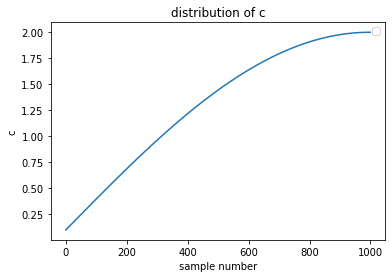

In [ ]:
len_train_set=2000
train_labels = np.zeros(len_train_set)
list_c_train = np.zeros(len_train_set)
T=0.34
train_set = []
index = 0
iterations = 1

Cmin=0.1
Cmax=2.0
C=(Cmax-Cmin)*np.sin(np.linspace(0,np.pi/2,len_train_set/2))+Cmin # Fonction sinus
#C=Cmin+(Cmax-Cmin)*(np.cos(np.linspace(-np.pi,0,len_train_set/2))+1)/2
plt.plot(C)
plt.title('distribution of c')
plt.ylabel('c')
plt.xlabel('sample number')
plt.legend()

In [ ]:
for c in C:
    clear_output()
    print('{}/1000'.format(iterations))
    list_c_train[index] = c
    list_c_train[index+1] = c
    diff_data, wave_data = get_samples(c,T)
    train_set.append(diff_data)
    train_set.append(wave_data)
    train_labels[index] = 0
    train_labels[index+1] = 1
    index = index + 2
    iterations += 1

train_set = np.array(train_set)
sol_len=len(train_set[0])

1000/1000


On peut constater que, dans le plot ci dessous, l'ensemble des solutions wave pour le training set occupe une diversité riche qui permettra un bon apprentissage.

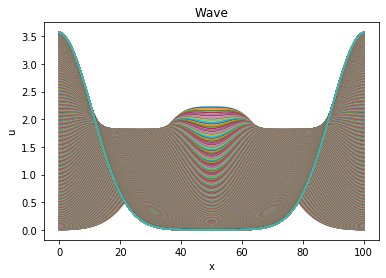

In [ ]:
for i in range(int(len_train_set/2)):
  plt.plot(train_set[2*i+1])
  plt.xlabel('x')
  plt.ylabel('u')
  plt.title('Wave')

De même pour les solutions diffusions.

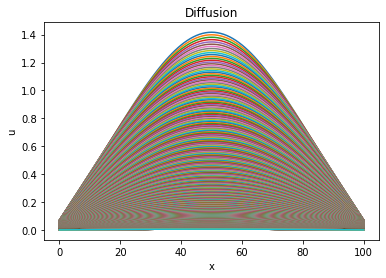

In [ ]:
for i in range(int(len_train_set/2)):
  plt.plot(train_set[2*i])
  plt.xlabel('x')
  plt.ylabel('u')
  plt.title('Diffusion')

Le reseau de neurones est simplifé, ici il n'y a que deux couches denséments connectés.

In [ ]:
model_w = Sequential()
model_w.add(layers.Dense(50, activation='relu', input_dim=sol_len))
model_w.add(layers.Dense(1, activation='sigmoid'))

print(model_w.summary())

model_w.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,151
Trainable params: 5,151
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

model_w.fit(train_set,
          train_labels,
          batch_size=500,
          epochs=100,
          validation_split=0.2,
          verbose=1)




Train on 1600 samples, validate on 400 samples
Epoch 1/100





1600/1600 [==============================] - 1s 363us/step - loss: 0.8915 - acc: 0.3244 - val_loss: 0.5575 - val_acc: 1.0000
Epoch 2/100
1600/1600 [==============================] - 0s 10us/step - loss: 0.5082 - acc: 0.7088 - val_loss: 0.4236 - val_acc: 1.0000
Epoch 3/100
1600/1600 [==============================] - 0s 8us/step - loss: 0.4272 - acc: 0.9031 - val_loss: 0.3833 - val_acc: 1.0000
Epoch 4/100
1600/1600 [==============================] - 0s 9us/step - loss: 0.3945 - acc: 0.9850 - val_loss: 0.3632 - val_acc: 1.0000
Epoch 5/100
1600/1600 [==============================] - 0s 10us/step - loss: 0.3761 - acc: 0.9913 - val_loss: 0.3507 - val_acc: 1.0000
Epoch 6/100
1600/1600 [==============================] - 0s 9us/step - loss: 0.3627 - acc: 0.9856 - val_loss: 0.3420 - val_acc: 1.0000
Epoch 7/100
1600/1600 [==============================] - 0s 9us/step - loss: 0.3531 - acc: 0.9887 - val_loss: 0.3359 - val_acc: 1.0

Ici je crée un ensemble test de 400 éléments.

In [ ]:
len_test_set=400
test_labels = np.zeros(len_test_set)
c_test = np.zeros(len_test_set)
T=0.34
test_set = []
index = 0
iterations = 1

for c in np.linspace(Cmin,Cmax,len_test_set/2):
    clear_output()
    print('{}/200'.format(iterations))
    c_test[index] = c
    c_test[index+1] = c
    diff_data, wave_data = get_samples(c,T)
    test_set.append(diff_data)
    test_set.append(wave_data)
    test_labels[index] = 0
    test_labels[index+1] = 1
    index = index + 2
    iterations += 1

test_set = np.array(test_set)

200/200


In [ ]:
pred=model_w.predict(test_set)

Le separateur entre les deux classes 0 et 1 est 0.5

In [ ]:
prediction=[]
for p in pred:
  if p[0]>0.5:
    prediction=prediction+[1]
  else:
    prediction=prediction+[0]

prediction=np.array(prediction)

Print la frequence d'erreurs

In [ ]:
frequence_error=(prediction!=test_labels).sum()/len_test_set

print("The frequence of errors on w is ", frequence_error)

The frequence of errors on w is  0.0


Dans cette partie, c est predie pour la diffusion.

In [ ]:
train_set_diffusion=[]
train_c_diffusion=[]
for i in range(int(len_train_set/2)):
  train_set_diffusion=train_set_diffusion+[train_set[2*i]]
  train_c_diffusion=train_c_diffusion+[list_c_train[2*i]]
  
train_set_diffusion=np.array(train_set_diffusion)
train_c_diffusion=np.array(train_c_diffusion)

La fonction loss mean_squared_error est remplacé par mean_absolute_error

In [ ]:
model_c_dif = Sequential()
model_c_dif.add(layers.Dense(65, activation='relu', input_dim=sol_len))
model_c_dif.add(layers.Dense(30, activation='relu'))
model_c_dif.add(layers.Dense(1,activation='linear'))

print(model_c_dif.summary())

model_c_dif.compile(loss='mean_absolute_error', optimizer='Adam') # mean_squared_error est remplacé par mean_absolute_error

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 65)                6630      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1980      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_c_dif.fit(train_set_diffusion,
          train_c_diffusion,
          batch_size=10,
          epochs=30,
          validation_split=0.2,
          verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 0s 457us/step - loss: 0.9643 - val_loss: 1.5721
Epoch 2/30
800/800 [==============================] - 0s 163us/step - loss: 0.4608 - val_loss: 0.7086
Epoch 3/30
800/800 [==============================] - 0s 170us/step - loss: 0.1287 - val_loss: 0.2747
Epoch 4/30
800/800 [==============================] - 0s 164us/step - loss: 0.0784 - val_loss: 0.2290
Epoch 5/30
800/800 [==============================] - 0s 160us/step - loss: 0.0524 - val_loss: 0.1565
Epoch 6/30
800/800 [==============================] - 0s 161us/step - loss: 0.0327 - val_loss: 0.1230
Epoch 7/30
800/800 [==============================] - 0s 147us/step - loss: 0.0288 - val_loss: 0.0913
Epoch 8/30
800/800 [==============================] - 0s 156us/step - loss: 0.0232 - val_loss: 0.0998
Epoch 9/30
800/800 [==============================] - 0s 160us/step - loss: 0.0210 - val_loss: 0.0849
Epoch 10/30
800/800 [===============

test_set_diffusion est cree pour tester le model.

In [ ]:
test_set_diffusion=[]
test_c_diffusion=[]
for i in range(int(len_test_set/2)):
  test_set_diffusion=test_set_diffusion+[test_set[2*i]]
  test_c_diffusion=test_c_diffusion+[c_test[2*i]]
  
test_set_diffusion=np.array(test_set_diffusion)
test_c_diffusion=np.array(test_c_diffusion)

In [ ]:
pred_c=model_c_dif.predict(test_set_diffusion)
prediction=[]
for t in pred_c:
    prediction=prediction+[t[0]]
prediction=np.asarray(prediction)

variance=sum(abs(prediction-test_c_diffusion))/len(test_c_diffusion)
print("L'erreur moyenne est ",round(variance,3))

L'erreur moyenne est  0.014


Auparavant l'erreur moyenne se situait vers 0.06

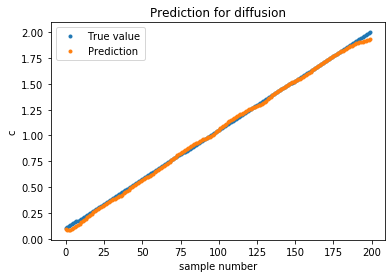

In [ ]:
plt.plot(test_c_diffusion,'.',label="True value")
plt.plot(pred_c,'.', label="Prediction")
plt.ylabel('c')
plt.xlabel('sample number')
plt.title('Prediction for diffusion')
plt.legend()

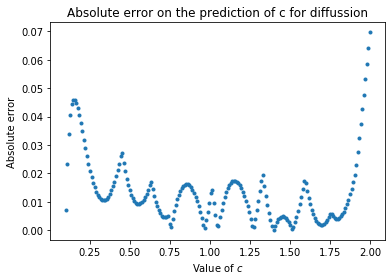

In [ ]:
abs_err_c_diffusion=np.linalg.norm(test_c_diffusion - pred_c.T,axis=0)
plt.figure()
plt.plot(test_c_diffusion,abs_err_c_diffusion,'.')
plt.title("Absolute error on the prediction of c for diffussion")
plt.xlabel("Value of $c$")
plt.ylabel('Absolute error')
plt.show()

Prediction de c pour la wave.

In [ ]:
train_set_wave=[]
train_c_wave=[]
for i in range(int(len_train_set/2)):
  train_set_wave=train_set_wave+[train_set[2*i+1]]
  train_c_wave=train_c_wave+[list_c_train[2*i+1]]
  
train_set_wave=np.array(train_set_wave)
train_c_wave=np.array(train_c_wave)

De même que pour la diffusion, le model a 3 couches denses.

In [ ]:
model_c_wave = Sequential()
model_c_wave.add(layers.Dense(65, activation='relu', input_dim=sol_len))
model_c_wave.add(layers.Dense(30, activation='relu'))
model_c_wave.add(layers.Dense(1,activation='linear'))

print(model_c_wave.summary())

model_c_wave.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 65)                6630      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1980      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_c_wave.fit(train_set_wave,
          train_c_wave,
          batch_size=50,
          epochs=50,
          validation_split=0.2,
          verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 0s 492us/step - loss: 0.3911 - val_loss: 0.1670
Epoch 2/50
800/800 [==============================] - 0s 38us/step - loss: 0.0396 - val_loss: 4.5741e-04
Epoch 3/50
800/800 [==============================] - 0s 40us/step - loss: 0.0071 - val_loss: 0.0092
Epoch 4/50
800/800 [==============================] - 0s 41us/step - loss: 0.0017 - val_loss: 0.0171
Epoch 5/50
800/800 [==============================] - 0s 38us/step - loss: 6.2925e-04 - val_loss: 0.0127
Epoch 6/50
800/800 [==============================] - 0s 46us/step - loss: 3.6444e-04 - val_loss: 0.0099
Epoch 7/50
800/800 [==============================] - 0s 38us/step - loss: 2.9550e-04 - val_loss: 0.0087
Epoch 8/50
800/800 [==============================] - 0s 48us/step - loss: 2.4297e-04 - val_loss: 0.0083
Epoch 9/50
800/800 [==============================] - 0s 42us/step - loss: 2.0754e-04 - val_loss: 0.0072
Epoch 10/50
800/800 

Teste du model:

In [ ]:
test_set_wave=[]
test_c_wave=[]
for i in range(int(len_test_set/2)):
  test_set_wave=test_set_wave+[test_set[2*i+1]]
  test_c_wave=test_c_wave+[c_test[2*i+1]]
  
test_set_wave=np.array(test_set_wave)
test_c_wave=np.array(test_c_wave)

In [ ]:
pred_c_wave=model_c_wave.predict(test_set_wave)
prediction_wave=[]
for t in pred_c_wave:
    prediction_wave=prediction_wave+[t[0]]
prediction_wave=np.asarray(prediction_wave)

variance=sum(abs(prediction_wave-test_c_wave))/len(test_c_wave)
print("L'erreur moyenne est ",round(variance,3))

L'erreur moyenne est  0.004


Auparavant l'erreur moyenne se situait vers 0.03

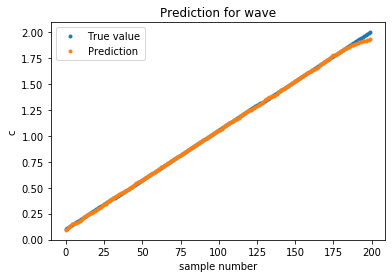

In [ ]:
plt.plot(test_c_wave,'.',label="True value")
plt.plot(pred_c_wave,'.', label="Prediction")
plt.ylabel('c')
plt.xlabel('sample number')
plt.title('Prediction for wave')
plt.legend()

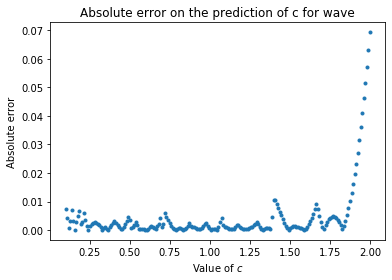

In [ ]:
abs_err_c_wave=np.linalg.norm(test_c_wave - pred_c_wave.T,axis=0)
plt.figure()
plt.plot(test_c_wave,abs_err_c_wave,'.')
plt.title("Absolute error on the prediction of c for wave")
plt.xlabel("Value of $c$")
plt.ylabel('Absolute error')
plt.show()